# Cepheids Data Exploration

- Gabriel Wendell Celestino Rocha
- Leonardo Andrade de Almeida

---

## 0. Setup

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.collections import PolyCollection, LineCollection

from loguru import logger
from numba import jit, njit
from scipy.stats import sem
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

- ### Aesthetic: single plot

In [2]:
%matplotlib inline

cm_font = FontProperties(fname  = 'CutiveMono-Regular.ttf')
gs_font = FontProperties(fname  = 'GillSans-Light.otf')
cm_size = 20

def sm_plot(grid = True, dark_background = False, use_tex = False, font_family = 'monospace', font_size = 15, 
            minorticks = True, major_ticks = True, minor_ticks = True, grid_linestyle = ':', grid_color = '0.50', 
            tick_length_minor = 5, tick_width_minor = 1, tick_length_major = 8, tick_width_major = 1, labelsize = 15):
    """
    Function to improve the aesthetics of Matplotlib graphs.
    """
    if dark_background:
        plt.style.use('dark_background')
    
    if grid:
        plt.grid(True, linestyle = grid_linestyle, color = grid_color, zorder = 0)
    else:
        plt.grid(False)
    
    plt.rcParams['text.usetex'] = use_tex
    plt.rcParams['font.family'] = font_family
    plt.rcParams['font.size'] = font_size
    
    if minorticks:
        plt.minorticks_on()
    else:
        plt.minorticks_off()
    
    if minor_ticks:
        plt.tick_params(axis = 'both', which = 'minor', direction = "in", 
                        top = True, right = True, length = tick_length_minor, 
                        width = tick_width_minor, labelsize = labelsize)
    
    if major_ticks:
        plt.tick_params(axis = 'both', which = 'major', direction = "in", 
                        top = True, right = True, length = tick_length_major, 
                        width = tick_width_major, labelsize = labelsize)

- ### **Aesthetics: plot axes**

In [3]:
def sm_plot_mod(ax, grid = True, dark_background = False, use_tex = False, font = 'monospace', font_size = 15, 
                minor_ticks = True, minor_tick_params = True, major_tick_params = True):
    
    if dark_background:
        plt.style.use('dark_background')
    else:
        plt.style.use('default')

    ax.grid(grid, linestyle = ':', color = '0.50')
    
    plt.rcParams['font.family'] = font
    plt.rcParams['font.size'] = font_size
    
    plt.rcParams['text.usetex'] = use_tex
    
    if minor_ticks:
        ax.minorticks_on()
    else:
        ax.minorticks_off()

    if minor_tick_params:
        ax.tick_params(axis = 'both', which = 'minor', direction = "in", 
                       top = True, right = True, length = 5, width = 1, labelsize = font_size)

    if major_tick_params:
        ax.tick_params(axis = 'both', which = 'major', direction = "in", 
                       top = True, right = True, length = 8, width = 1, labelsize = font_size)

---

## 1. Background

Cepheids are stars whose brightness oscillates with a stable period, the logarithm of which appears to be strongly correlated with their mean absolute magnitude. Traditionally, these stars form part of the "distance ladder" establishing the relationship between cosmological redshift and distance, i.e. the Hubble expansion rate. The absolute luminosity for a given period is measured in our Galaxy, or one very nearby, where the distance can be determined by geometric paralax; measured fluxes and periods can then be used to estimate the distance to larger numbers of more distant galaxies where other distance proxies such as supernova luminosities are calibrated. This procedure requires the period-luminosity relation to be universal (the same relation must hold in every galaxy).

We'll be using this data set to explore some aspects of hierarchical models, which are a natural way to handle data for populations of sources. In this notebook, we'll get familiar with a particular data set (from [Riess et al. 2011](https://ui.adsabs.harvard.edu/abs/2011ApJ...730..119R/abstract)), and think about what kind of model might be appropriate.

---

## 2. Data Exploration

The data tables were extracted from the article itself and saved in `data` folder.

### 2.1 Cepheids data

- `R11ceph.dat`
> Measurements of a number of Cepheids in each galaxy.

**HEADER**
```
# R11ceph.dat
#
# This is a processed version of the R11 cepheid data
# (Riess et al. 2011 [R11], ApJ, 730, 119, Table 2)
#
# Columns:
#     id: the ID of the cepheid
#    gal: the NGC number of the host galaxy
#      m: mags m are computed using m = F160W - 0.41*(V_I)
#   merr: mag errs are just those in the F160W mags
#         (errors in V-I were not given in R11)
#      P: period P is in days (errors in the Period were not given)
# logO_H: this is actually log[O/H], not 12 + log[O/H] as in R11
#   bias: this is the crowding bias *already applied* by R11
#
# Notes:
# - cepheid with id 102255 was excluded since its mag error is 99.0

```

### 2.2 Redshifts data

- `R11resh.dat`
> Lists the redshifts for a sample of galaxies.

**HEADER**
```
# R11redsh.dat
#
# Redshifts to the Cepheid hosts in R11ceph.dat
#
# Columns:
#    gal: the NGC number of the host galaxy
#      z: redshift
```

### 2.3 Dataframe master

The master dataframe consists of the union of the two datasets presented above. It is also important to reorganize the data so that it is indexed based on the galaxy analyzed (NGC number). The base-$10$ $\log$ of the period for each Cepheid is also calculated.

In [4]:
data_path = 'data/'
cepheids_path = data_path + 'R11ceph.dat'
redshift_path = data_path + 'R11redsh.dat'

cepheids = pd.read_csv(cepheids_path, sep = ' ', skiprows = 18)
redshifts = pd.read_csv(redshift_path, sep = ' ', skiprows = 8)


cols_to_rename_cepheids = {'#':'id', 'Unnamed: 1':'gal', 'id':'m', 'Unnamed: 3':'merr',
                 'gal':'P', 'Unnamed: 5':'logO_H', 'Unnamed: 6':'bias'}
cols_to_rename_redshifts = {'#':'gal', 'Unnamed: 1':'trash1', 'gal':'trash2', 'z':'z'}

cepheids = cepheids.rename(columns = cols_to_rename_cepheids)
cepheids = cepheids.iloc[:,:7]

redshifts = redshifts.rename(columns = cols_to_rename_redshifts)
redshifts = redshifts.drop(['trash1', 'trash2'], axis = 1)

cepheids['logP'] = np.log10(cepheids['P'])
cols = list(cepheids.columns)
col_logP = cols.pop(cols.index('logP'))
cols.insert(5, col_logP)
cepheids = cepheids[cols]



df = pd.merge(cepheids, redshifts, on = 'gal', how = 'left')
cols_ = list(df.columns)
col_z = cols_.pop(cols_.index('z'))
cols_.insert(2, col_z)
df = df[cols_]

print('DATAFRAME MASTER =D')
print(df.shape)
display(df)

DATAFRAME MASTER =D
(646, 9)


,id,gal,z,m,merr,P,logP,logO_H,bias
0,27185,4536,0.006031,24.5123,0.31,13.000,1.113943,-3.46,0.13
1,42353,4536,0.006031,25.9907,0.74,13.070,1.116276,-3.03,0.37
2,50718,4536,0.006031,24.1492,0.42,13.730,1.137671,-3.36,0.28
3,72331,4536,0.006031,24.4751,0.44,13.910,1.143327,-3.19,0.22
4,65694,4536,0.006031,24.8582,0.38,14.380,1.157759,-3.10,0.39
...,...,...,...,...,...,...,...,...,...
641,29163,4258,0.001494,24.1520,0.57,6.739,0.828595,-3.25,0.38
642,34729,4258,0.001494,22.6608,0.50,14.920,1.173769,-3.25,0.00
643,89375,4258,0.001494,22.4128,0.45,12.380,1.092721,-3.11,0.42
644,246695,4258,0.001494,22.5969,0.40,11.200,1.049218,-3.11,0.49


---

## 3. Plots Analysis

### 3.1 Apparent Magnitude Analysis

- ### Period vs Apparent Magnitude (Grouped by galaxies)

Smaller magnitudes mean brighter sources, so we need to reverse the `Y` axis.

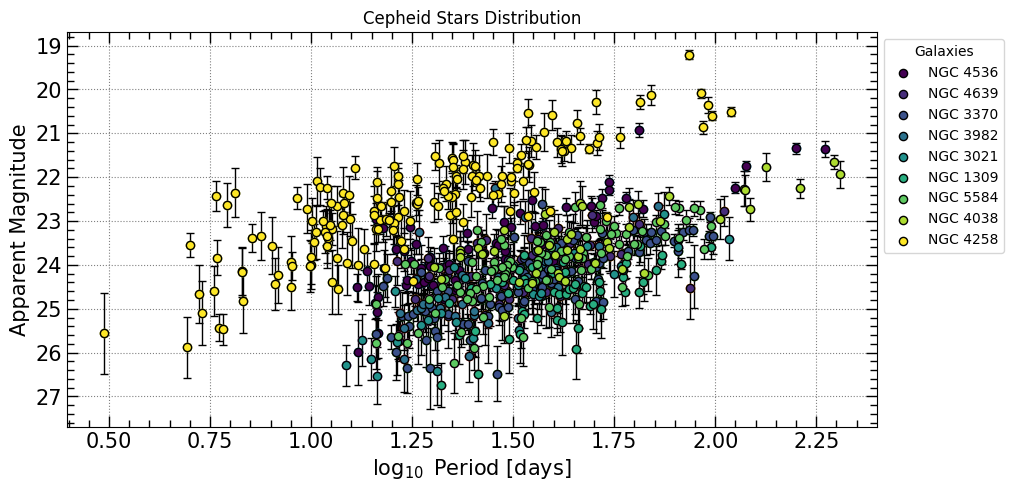

In [5]:
fig, ax = plt.subplots(figsize = (12, 5))

colormap_name = 'viridis'
unique_galaxies = df['gal'].unique()
colors = plt.get_cmap(colormap_name)(np.linspace(0, 1, len(unique_galaxies)))
#colors = plt.cm.tab10(np.linspace(0, 1, len(unique_galaxies)))

for color, gal in zip(colors, unique_galaxies):
    subset = df[df['gal'] == gal]
    ax.scatter(
        subset['logP'], subset['m'], color = color, s = 35, edgecolor = 'k', zorder = 3, label = f'NGC {gal}'
    )
    ax.errorbar(subset['logP'], subset['m'], yerr = subset['merr'], fmt = 'o', 
                ecolor = 'k', elinewidth = 1, zorder = 2, capsize = 3, lw = 1)


ax.set_xlabel(r'$\log_{10}$ Period [days]', fontsize = 15)
ax.set_ylabel(r'Apparent Magnitude', fontsize = 15)
ax.set_title(r'Cepheid Stars Distribution')

ax.invert_yaxis()  
ax.legend(title = 'Galaxies', loc = 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect = [0, 0, 0.85, 1])  

sm_plot()

### 3.2 Absolute Magnitude Analysis

- ### Period vs Absolute Magnitude (Grouped by Galaxies)

Of course, the apparent magnitude (related to the observed flux) is not a good basis for comparing Cepheid populations in galaxies at different distances from us. We'll want to convert this to the absolute magnitude, an intrinsic property. Also, the host galaxies in the `R11` sample are all very nearby (check the maximum redshift read in above), so let's assume that distance is proportional to redshift $z$ via Hubble's law:

Thus, the process involves calculating the distance $d_L$ through Hubble's law and using the result to obtain the absolute magnitude $M$. In symbols:

$$
\boxed{d_{L}\left(z\right)=\frac{cz}{H_{0}}\implies M = m + 5 \log_{10}\left[\frac{d_\mathrm{L}(z)}{\mathrm{Mpc}}\right] + 25}
$$

where $c=3\times10^{5}$ $\text{km s}^{-1}$ and $H_{0}=70$ $\text{km s}^{-1}\text{ Mpc}^{-1}$.

Some comments...

1. Note that having these constants correct is not important for accounting for the relative distance to each galaxy, i.e. getting their period-luminosity scatterplots to line up;
2. Note that, since we're assuming a perfectly known, additive translation from $m$ to $M$, `merr` describes the uncertainty either `m` or `M`, so
```
df['Merr'] == df['merr']
``` 

In [6]:
c = 3.0e5    # [c] = km/s
H0 = 70.0    # [H0] = km/s/Mpc

df['dL'] = c*df['z']/H0
df['M'] = df['m'] - 5*np.log10(df['dL']) - 25
df['Merr'] = df['merr']

cols = list(df.columns)
col_dL = cols.pop(cols.index('dL'))
cols.insert(3, col_dL)
col_M = cols.pop(cols.index('M'))
cols.insert(4, col_M)
col_Merr = cols.pop(cols.index('Merr'))
cols.insert(5, col_Merr)


df = df[cols]

print('TREATED DATAFRAME')
print(df.shape)
display(df)

TREATED DATAFRAME
(646, 12)


,id,gal,z,dL,M,Merr,m,merr,P,logP,logO_H,bias
0,27185,4536,0.006031,25.847143,-7.549763,0.31,24.5123,0.31,13.000,1.113943,-3.46,0.13
1,42353,4536,0.006031,25.847143,-6.071363,0.74,25.9907,0.74,13.070,1.116276,-3.03,0.37
2,50718,4536,0.006031,25.847143,-7.912863,0.42,24.1492,0.42,13.730,1.137671,-3.36,0.28
3,72331,4536,0.006031,25.847143,-7.586963,0.44,24.4751,0.44,13.910,1.143327,-3.19,0.22
4,65694,4536,0.006031,25.847143,-7.203863,0.38,24.8582,0.38,14.380,1.157759,-3.10,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...
641,29163,4258,0.001494,6.402857,-4.879869,0.57,24.1520,0.57,6.739,0.828595,-3.25,0.38
642,34729,4258,0.001494,6.402857,-6.371069,0.50,22.6608,0.50,14.920,1.173769,-3.25,0.00
643,89375,4258,0.001494,6.402857,-6.619069,0.45,22.4128,0.45,12.380,1.092721,-3.11,0.42
644,246695,4258,0.001494,6.402857,-6.434969,0.40,22.5969,0.40,11.200,1.049218,-3.11,0.49


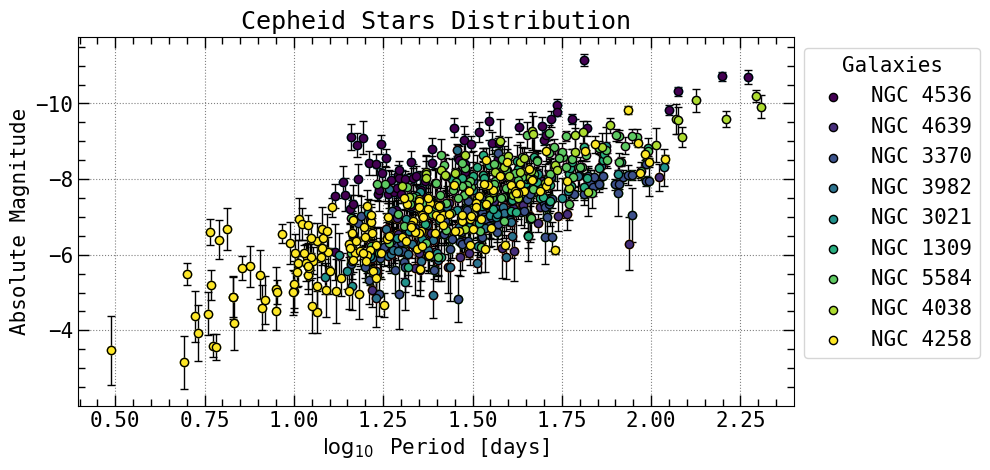

In [7]:
fig, ax = plt.subplots(figsize = (12, 5))

colormap_name = 'viridis'
unique_galaxies = df['gal'].unique()
colors = plt.get_cmap(colormap_name)(np.linspace(0, 1, len(unique_galaxies)))
#colors = plt.cm.tab10(np.linspace(0, 1, len(unique_galaxies)))

for color, gal in zip(colors, unique_galaxies):
    subset = df[df['gal'] == gal]
    ax.scatter(
        subset['logP'], subset['M'], color = color, s = 35, edgecolor = 'k', zorder = 3, label = f'NGC {gal}'
    )
    ax.errorbar(subset['logP'], subset['M'], yerr = subset['Merr'], fmt = 'o', 
                ecolor = 'k', elinewidth = 1, zorder = 2, capsize = 3, lw = 1)


ax.set_xlabel(r'$\log_{10}$ Period [days]')
ax.set_ylabel(r'Absolute Magnitude')
ax.set_title(r'Cepheid Stars Distribution')

ax.invert_yaxis()  
ax.legend(title = 'Galaxies', loc = 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect = [0, 0, 0.85, 1])  

sm_plot()

- $\Diamond$ **CHECKPOINT :** Pretty much! We should see a fairly clear trend. $\Diamond$

Let's visualize the distribution of Cepheid stars in each galaxy separately.

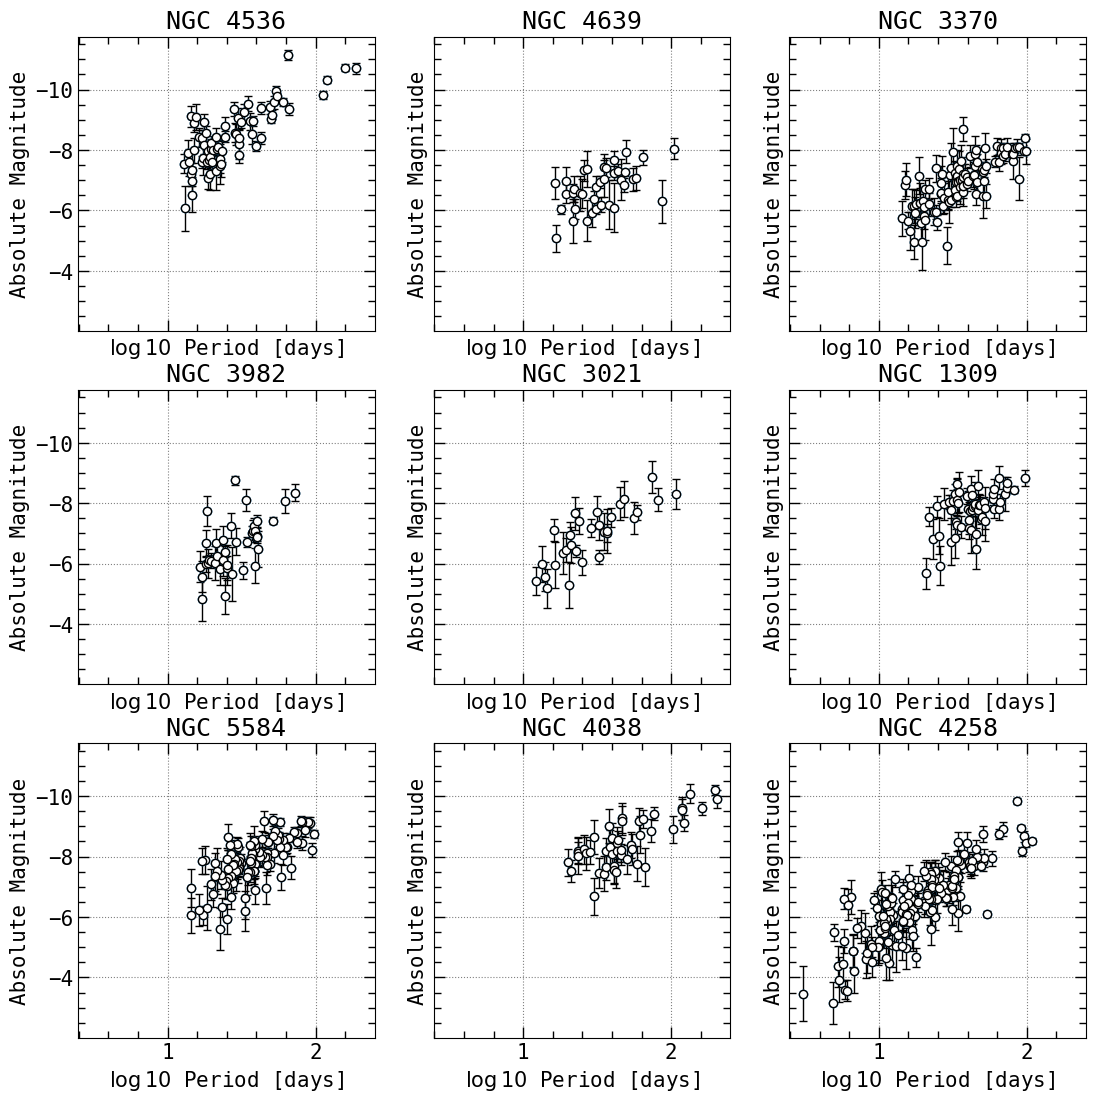

In [8]:
unique_galaxies = df['gal'].unique()

fig, axs = plt.subplots(3, 3, figsize = (13, 13), sharex = True, sharey = True)
axs = axs.flatten()

for ax, gal in zip(axs, unique_galaxies):
    subset = df[df['gal'] == gal]
    ax.scatter(
        subset['logP'], subset['M'], color = 'w', s = 35, edgecolor = 'k', zorder = 3, label = f'NGC {gal}'
    )
    ax.errorbar(subset['logP'], subset['M'], yerr = subset['Merr'], fmt = 'o', 
                ecolor = 'k', elinewidth = 1, zorder = 2, capsize = 3, lw = 1)
    ax.invert_yaxis()  
    
    ax.set_title(f'NGC {gal}')
    ax.set_xlabel(f'$\log10$ Period [days]')
    ax.set_ylabel(f'Absolute Magnitude')
    sm_plot_mod(ax)

### 3.3 Metallicity Analysis

- ### Metallicity vs Absolute Magnitude (Grouped by Galaxies)

Let's visualize the distribution of Cepheid stars based on their metallicity. The abundance ratio is the common logarithm of the ratio of a star's $\text{O}$ abundance compared to that of the Sun. In symbols:

$$
\boxed{\left[\text{O}/\text{H}\right]=\log_{10}\left(\frac{N_{\text{O}}}{N_{\text{H}}}\right)_{\star}-\log_{10}\left(\frac{N_{\text{O}}}{N_{\text{H}}}\right)_{\odot}}
$$

This type of analysis is important to assess the impact of the metallicity of the Cepheid (and even the host galaxy) on the $(P-L)$ relationship. The result may indicate that perhaps metallicity is a component that should be taken into consideration and that influences the $(P-L)$ relationship.

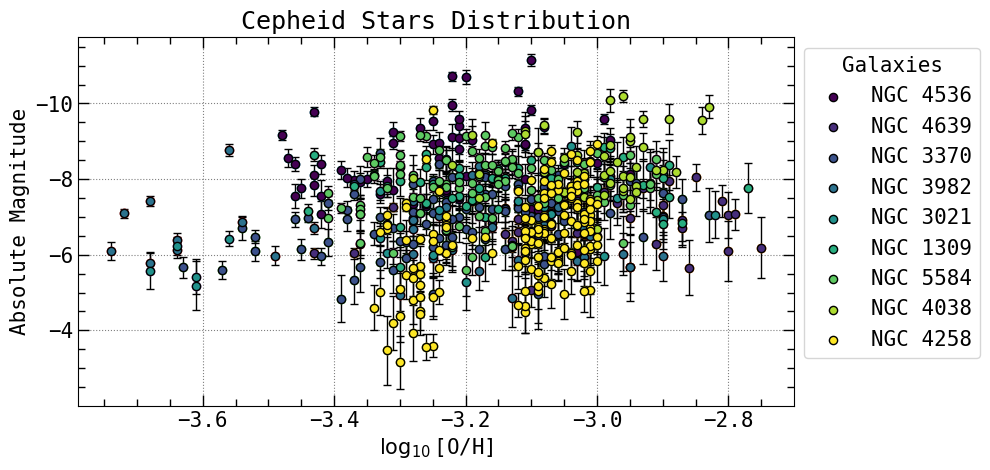

In [9]:
fig, ax = plt.subplots(figsize = (12, 5))

colormap_name = 'viridis'
unique_galaxies = df['gal'].unique()
colors = plt.get_cmap(colormap_name)(np.linspace(0, 1, len(unique_galaxies)))
#colors = plt.cm.tab10(np.linspace(0, 1, len(unique_galaxies)))

for color, gal in zip(colors, unique_galaxies):
    subset = df[df['gal'] == gal]
    ax.scatter(
        subset['logO_H'], subset['M'], color = color, s = 35, edgecolor = 'k', zorder = 3, label = f'NGC {gal}'
    )
    ax.errorbar(subset['logO_H'], subset['M'], yerr = subset['Merr'], fmt = 'o', 
                ecolor = 'k', elinewidth = 1, zorder = 2, capsize = 3, lw = 1)


ax.set_xlabel(r'$\log_{10}$[O/H]')
ax.set_ylabel(r'Absolute Magnitude')
ax.set_title(r'Cepheid Stars Distribution')

ax.invert_yaxis()  
ax.legend(title = 'Galaxies', loc = 'upper left', bbox_to_anchor = (1, 1))
plt.tight_layout(rect = [0, 0, 0.85, 1])  

sm_plot()

**OBS:** The `bias` column is something that has already been applied by `R11`. If we were specialists we might second guess this, but for our purposes we can leave it alone.

$\Diamond$ **CHECKPOINT:** We would have to check in the paper whether the metallicity is expected to have an influence on the Cepheid luminosity or period (or, indeed, whether some metallicity-based correction has already been applied). Let's keep things relatively simple for this example by neglecting any of that, and focusing only on the supplied periods and magntitudes.

- ### Period vs Absolute Magnitude vs Metallicity

An important analysis to be made is to understand how the distribution of Cepheids occurs both in relation to the period and in relation to metallicity. Therefore, we will check the distribution of Cepheids grouped by metallicity.

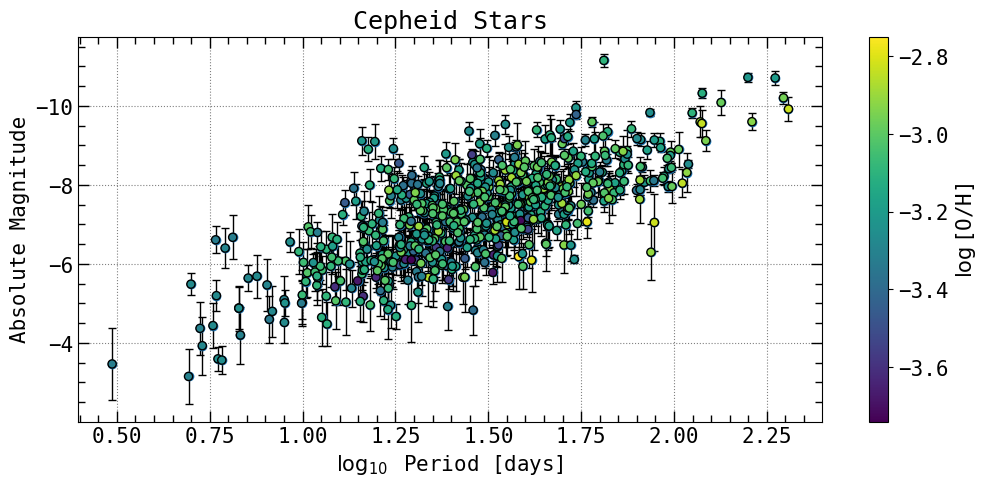

In [10]:
fig, ax = plt.subplots(figsize = (12, 5))

sc = ax.scatter(df['logP'], df['M'], c = df['logO_H'], cmap = 'viridis', s = 35, edgecolor = 'k', zorder = 3)
ax.errorbar(df['logP'], df['M'], yerr = df['Merr'], fmt = 'o', 
            ecolor = 'k', elinewidth = 1, zorder = 2, capsize = 3, lw = 1)

cbar = plt.colorbar(sc)
cbar.set_label(r'$\log$[O/H]')

ax.set_xlabel(r'$\log_{10}$ Period [days]')
ax.set_ylabel('Absolute Magnitude')
ax.set_title('Cepheid Stars')

ax.invert_yaxis()  
sm_plot()

### 3.4 Histograms Analysis

- ### Period Histograms

Based on the previous graphs, it is possible to notice that the distribution of periods is not uniform and varies from galaxy to galaxy. To better understand this behavior, let's look at period histograms for each galaxy

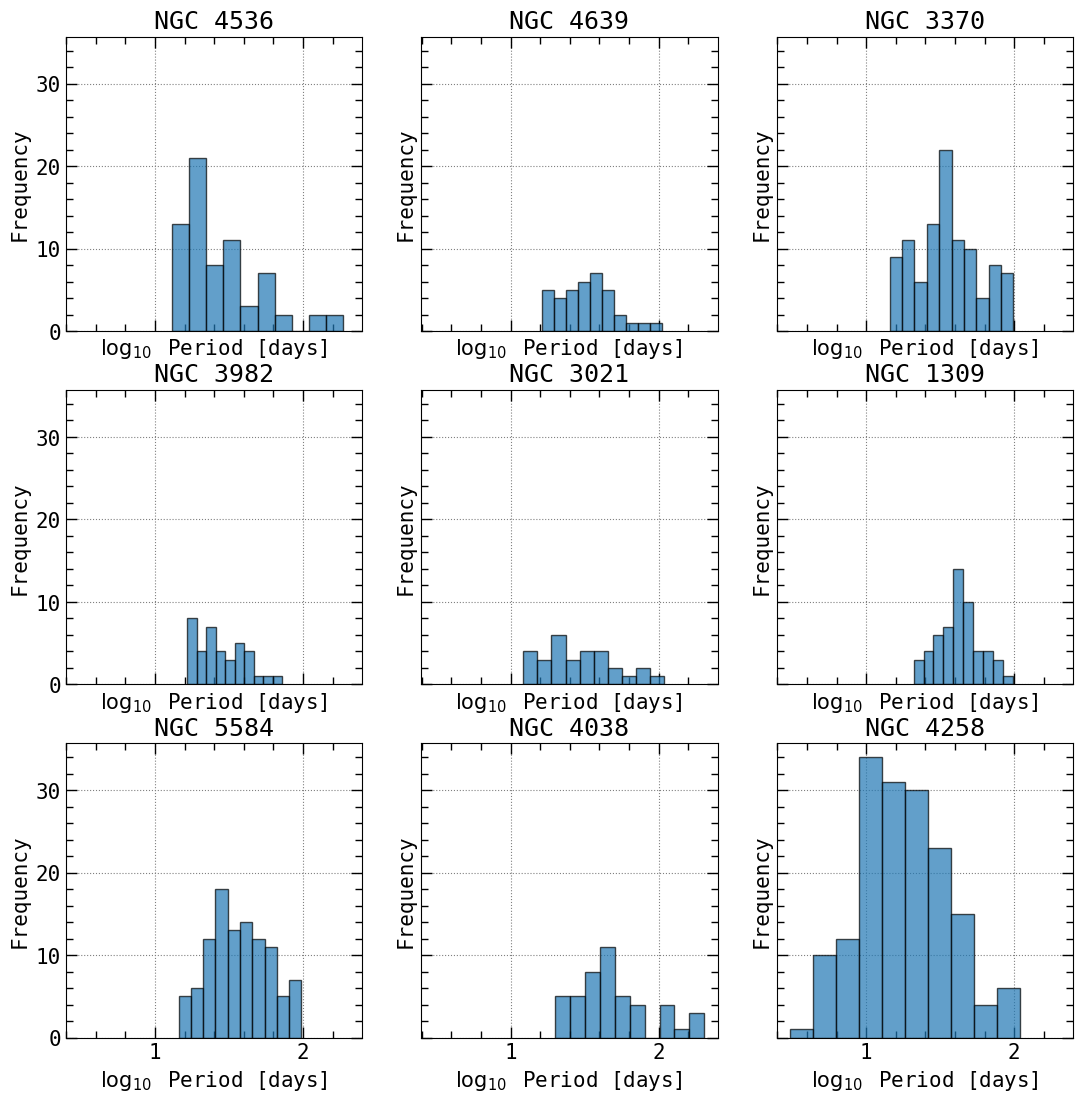

In [11]:
unique_galaxies = df['gal'].unique()

fig, axs = plt.subplots(3, 3, figsize = (13, 13), sharex = True, sharey = True)
axs = axs.flatten()

for ax, gal in zip(axs, unique_galaxies):
    subset = df[df['gal'] == gal]
    ax.hist(subset['logP'], bins = 10, edgecolor = 'k', alpha = 0.7, zorder = 2)  
    
    ax.set_title(f'NGC {gal}')
    ax.set_xlabel(r'$\log_{10}$ Period [days]')
    ax.set_ylabel(r'Frequency')
    sm_plot_mod(ax)

- ### Metallicity Histograms

Let us now look at the distribution of metallicities from the metallicity histogram of each galaxy.

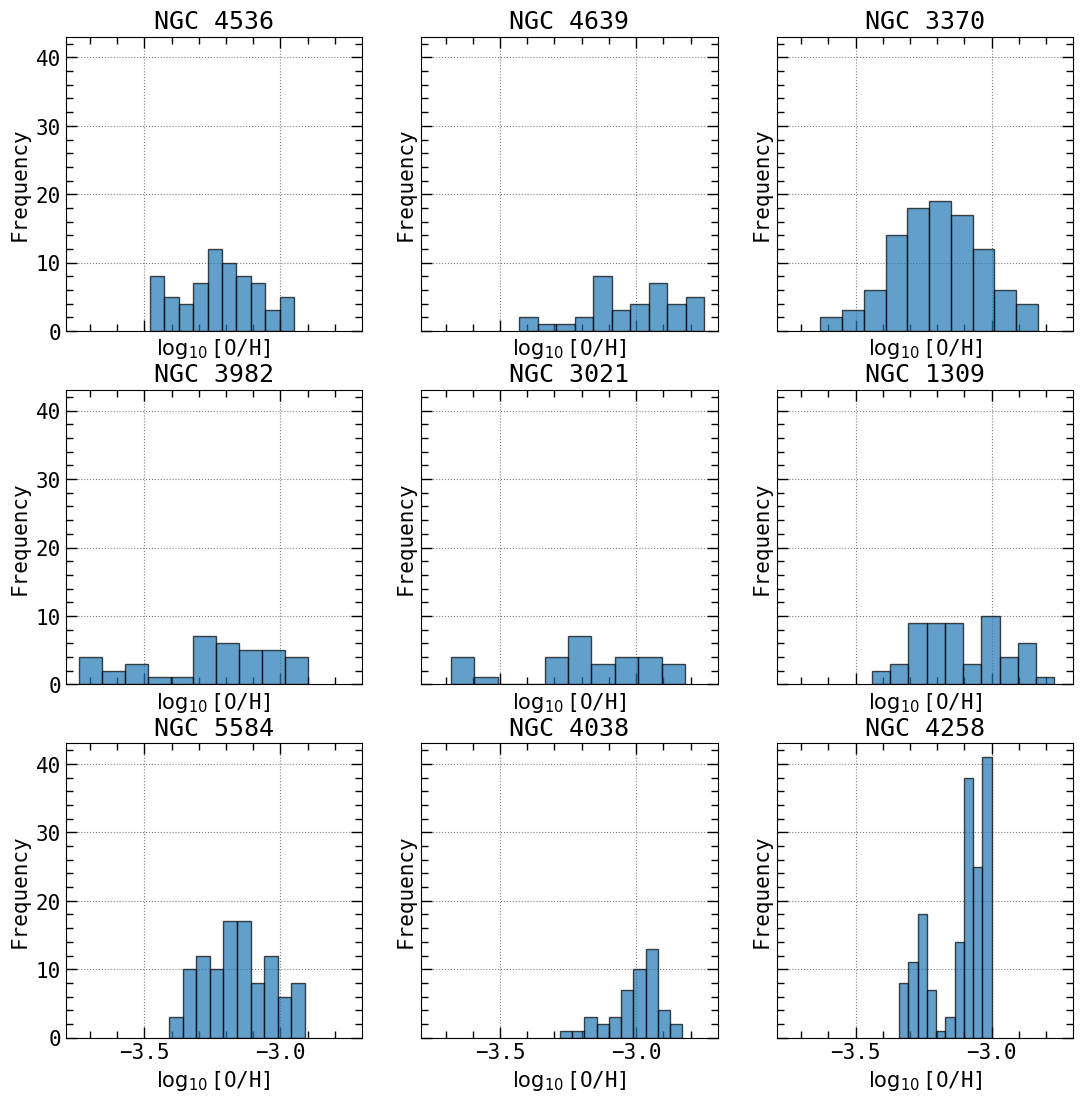

In [12]:
unique_galaxies = df['gal'].unique()

fig, axs = plt.subplots(3, 3, figsize = (13, 13), sharex = True, sharey = True)
axs = axs.flatten()

for ax, gal in zip(axs, unique_galaxies):
    subset = df[df['gal'] == gal]
    ax.hist(subset['logO_H'], bins = 10, edgecolor = 'k', alpha = 0.7, zorder = 2)  
    
    ax.set_title(f'NGC {gal}')
    ax.set_xlabel(r'$\log_{10}$[O/H]')
    ax.set_ylabel(r'Frequency')
    sm_plot_mod(ax)

$\Diamond$ **CHECKPOINT:** The most obvious explanation for this variation is a selection effect due to the **frequency with which each galaxy was observed** - we can't have measured periods much shorter or longer than the observation cadence with any fidelity.

### 3.5 Linear Regression

- ### Leonardo's suggestion

Divide the metallicity into six equally spaced metallicity intervals and apply a linear fit to each interval. The metallicity intervals obtained are as follows:

1. $\log_{10}\left[\text{O}/\text{H}\right]\in[-3.74, -3.58]$ ;
2. $\log_{10}\left[\text{O}/\text{H}\right]\in[-3.58, -3.41]$ ;
3. $\log_{10}\left[\text{O}/\text{H}\right]\in[-3.41, -3.25]$ ;
4. $\log_{10}\left[\text{O}/\text{H}\right]\in[-3.25, -3.08]$ ;
5. $\log_{10}\left[\text{O}/\text{H}\right]\in[-3.08, -2.92]$ ;
6. $\log_{10}\left[\text{O}/\text{H}\right]\in[-2.92, -2.75]$ .

This type of analysis allows us to firstly not only know the number of Cepheids whose metallicity is in each interval, but also to know how "inclined" the line adjusted for each metallicity "environment" studied is.

(1) Metallicity interval : [-3.74 , -3.58]
  - Angular coefficient = -2.9182
  - Linear coefficient = -2.1421
  - Standard error = 0.5570

(2) Metallicity interval : [-3.58 , -3.41]
  - Angular coefficient = -2.8143
  - Linear coefficient = -3.2827
  - Standard error = 1.3052

(3) Metallicity interval : [-3.41 , -3.25]
  - Angular coefficient = -3.2242
  - Linear coefficient = -2.4895
  - Standard error = 0.2330

(4) Metallicity interval : [-3.25 , -3.08]
  - Angular coefficient = -3.2419
  - Linear coefficient = -2.5798
  - Standard error = 0.2350

(5) Metallicity interval : [-3.08 , -2.92]
  - Angular coefficient = -3.0024
  - Linear coefficient = -2.8727
  - Standard error = 0.1775

(6) Metallicity interval : [-2.92 , -2.75]
  - Angular coefficient = -2.3311
  - Linear coefficient = -3.7203
  - Standard error = 0.5365



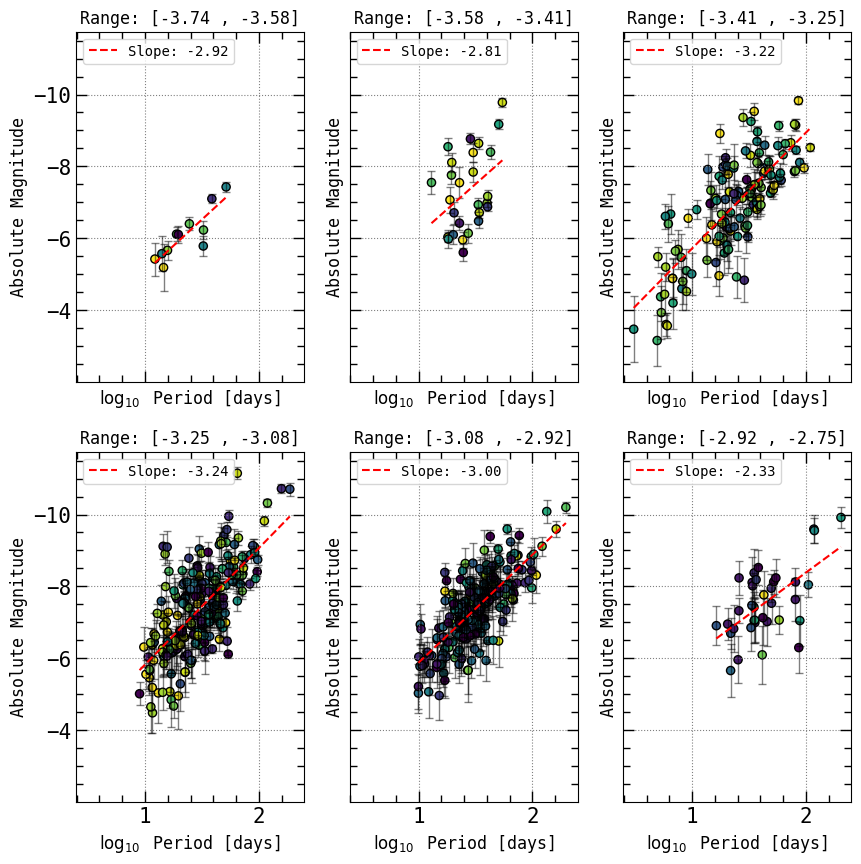

In [13]:
metallicity_bins = np.linspace(df['logO_H'].min(), df['logO_H'].max(), 7)
metallicity_labels = [f"[{metallicity_bins[i]:.2f} , {metallicity_bins[i+1]:.2f}]" for i in range(len(metallicity_bins)-1)]

fig, axs = plt.subplots(2, 3, figsize = (10, 10), sharex = True, sharey = True)
axs = axs.flatten()

# Plot each metallicity interval
for i, ax in enumerate(axs):
    # Filter data for the current metallicity interval
    mask = (df['logO_H'] >= metallicity_bins[i]) & (df['logO_H'] < metallicity_bins[i+1])
    subset = df[mask]
    
    sc = ax.scatter(
        subset['logP'], subset['M'], 
        c = subset['logO_H'], cmap = 'viridis', edgecolor = 'k', s = 35
    )

    ax.errorbar(subset['logP'], subset['M'], yerr = subset['Merr'], fmt = 'none', 
                ecolor = 'k', elinewidth = 1, capsize = 3, lw = 1, alpha = 0.5)
    
    # Fit a line to the subset of data
    if not subset.empty:
        model = LinearRegression()
        model.fit(subset[['logP']], subset['M'])
        slope = model.coef_[0]
        intercept = model.intercept_ 
        
        # Generate x values for the line plot
        x_vals = np.linspace(subset['logP'].min(), subset['logP'].max(), 100)
        # Predict y values based on the fitted model
        y_vals = model.predict(x_vals.reshape(-1, 1))
        
        ax.plot(x_vals, y_vals, linestyle = '--', color = 'r', label = f'Slope: {slope:.2f}')
        
        # Calculate the standard error of the slope
        residuals = subset['M'] - model.predict(subset[['logP']])
        residual_sum_of_squares = np.sum(residuals**2)
        degrees_of_freedom = len(subset) - 2  
        mean_squared_error = residual_sum_of_squares / degrees_of_freedom
        std_err = np.sqrt(mean_squared_error / np.sum((subset['logP'] - subset['logP'].mean())**2))

        print(f"({i+1}) Metallicity interval : {metallicity_labels[i]}")
        print(f"  - Angular coefficient = {slope:.4f}")
        print(f"  - Linear coefficient = {intercept:.4f}")
        print(f"  - Standard error = {std_err:.4f}\n")

    ax.set_title(f'Range: {metallicity_labels[i]}', fontsize = 12)
    ax.set_xlabel(r'$\log_{10}$ Period [days]', fontsize = 12)
    ax.set_ylabel('Absolute Magnitude', fontsize = 12)
    
    ax.legend(loc = 2, fontsize = 10)
    sm_plot_mod(ax)

ax.invert_yaxis()
plt.show()

- ### All Data

Let's now perform a linear fit taking into account all available data using Scipy

2024-08-20 14:40:44.822 | INFO     | __main__:<module>:57 - 
# STATISTICS
a = -7.2781 ± 0.0323, b = -3.1175 ± 0.1174'




# STATISTICS
a = -7.2781 ± 0.0323, b = -3.1175 ± 0.1174'



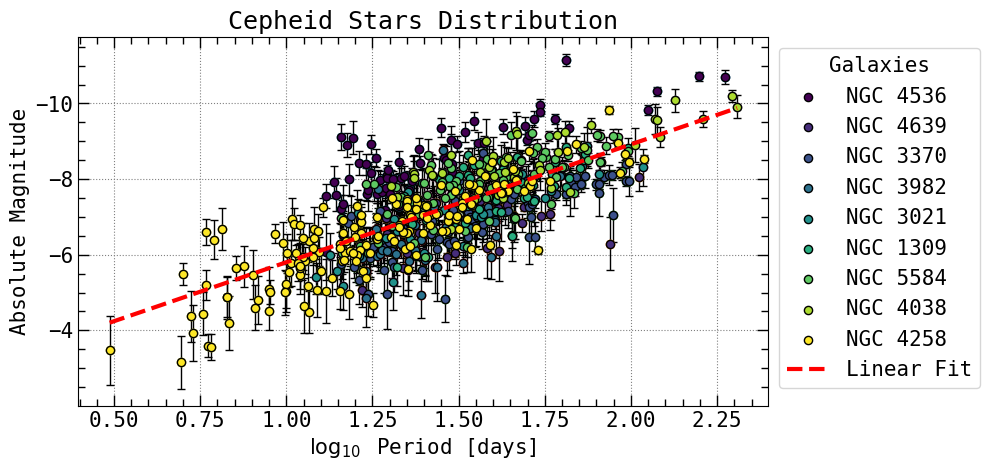

In [15]:
def meanfunc(x, a, b):
    return a + b * (x - global_pivot)

param_names = ['a', 'b', 'sigma']
param_labels = [r'$a$', r'$b$', r'$\sigma$']

global_pivot = df['logP'].mean()
df['Pivot'] = global_pivot

xx = np.linspace(df['logP'].min(), df['logP'].max(), len(df['Pivot']))
params, covariance = curve_fit(meanfunc, df['logP'], df['M'], p0=[0, 0])
a_opt, b_opt = params

param_errors = np.sqrt(np.diag(covariance))
a_std, b_std = param_errors



# Plot the linear fit
fig, ax = plt.subplots(figsize = (12, 5))

colormap_name = 'viridis'
unique_galaxies = df['gal'].unique()
colors = plt.get_cmap(colormap_name)(np.linspace(0, 1, len(unique_galaxies)))
#colors = plt.cm.tab10(np.linspace(0, 1, len(unique_galaxies)))

for color, gal in zip(colors, unique_galaxies):
    subset = df[df['gal'] == gal]
    ax.scatter(
        subset['logP'], subset['M'], color = color, s = 35, edgecolor = 'k', zorder = 3, label = f'NGC {gal}'
    )
    ax.errorbar(subset['logP'], subset['M'], yerr = subset['Merr'], fmt = 'o', 
                ecolor = 'k', elinewidth = 1, zorder = 2, capsize = 3, lw = 1)

ax.plot(xx, meanfunc(xx, a_opt, b_opt), ls = '--', lw = 3, color = 'r', label = 'Linear Fit', zorder = 4)
#ax.plot(x_vals, y_vals, ls = '-', lw = 3, color = 'k', label = 'Sklearn Fit', zorder = 5)
    
ax.set_xlabel(r'$\log_{10}$ Period [days]', fontsize = 15)
ax.set_ylabel(r'Absolute Magnitude', fontsize = 15)
ax.set_title(r'Cepheid Stars Distribution')

ax.invert_yaxis()  
ax.legend(title = 'Galaxies', loc = 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect = [0, 0, 0.85, 1])  

sm_plot()



# Log of informations
column_info = f"""
# STATISTICS
a = {a_opt:.4f} ± {a_std:.4f}, b = {b_opt:.4f} ± {b_std:.4f}'
"""

logger.add(lambda msg: print(msg, end = ''), format = "{message}", level = "INFO")
logger.info(column_info)

logger.remove()

---

## 4. Saving the dataset

Finally, we need to save the processed dataframe on our machine. We will save two files:

1. `R11treat.dat`: R11 dataframe processed throughout this stage of the project.
2. `R11treat_info.txt`: description of each column of the `R11treat.dat` dataframe and additional information.

The first step can be easily done using `Pandas`. For the second step, we will generate a log file with the dataframe information using `loguru`.

### 4.1 Pipeline

Let's record the pipeline used to process the data

- **Pipeline**

### 4.2 Treated dataframe

In [16]:
header = """
# R11treat.dat
#
# This is a processed and treated version of the Cepheid and redshift datas from R11.
# (Riess et al. 2011 [R11], ApJ, 730, 119, Table 2)
#
# The description of each column can be found in the R11treat_info.txt file.
#
"""

file_path = "data/R11treat.dat"

with open(file_path, 'w') as f:
    f.write(header + "\n")

df.to_csv(file_path, mode = 'a', sep = '\t', index = False)

### 4.3 Saving the infos with `loguru`

In [17]:
column_info = """
# R11treat.dat
#
# This is a processed and treated version of the Cepheid and redshift datas from R11.
# (Riess et al. 2011 [R11], ApJ, 730, 119, Table 2)
#
# Columns:
#      id: the ID of the cepheid
#     gal: the NGC number of the host galaxy
#       z: redshift of the host galaxy
#      dL: the distance computed via Hubble's law
#       M: abs mags M are computed using M = m + 5*log10(dL/Mpc) + 25
#    Merr: abs mags errs are just the mags m errs
#       m: mags m are computed using m = F160W - 0.41*(V_I)
#    merr: mag errs are just those in the F160W mags
#          (errors in V-I were not given in R11)
#       P: period P is in days (errors in the Period were not given)
#    logP: base-10log of the period for each Cepheid
#  logO_H: this is actually log[O/H], not 12 + log[O/H] as in R11
#    bias: this is the crowding bias *already applied* by R11
#
# Notes:
# - cepheid with id 102255 was excluded since its mag error is 99.0
"""

log_file_path = "data/R11treat_info.txt"

logger.add(log_file_path, format = "{message}", level = "WARNING")
logger.add(lambda msg: print(msg, end = ''), format = "{message}", level = "INFO")
logger.info(column_info)

logger.remove()


# R11treat.dat
#
# This is a processed and treated version of the Cepheid and redshift datas from R11.
# (Riess et al. 2011 [R11], ApJ, 730, 119, Table 2)
#
# Columns:
#      id: the ID of the cepheid
#     gal: the NGC number of the host galaxy
#       z: redshift of the host galaxy
#      dL: the distance computed via Hubble's law
#       M: abs mags M are computed using M = m + 5*log10(dL/Mpc) + 25
#    Merr: abs mags errs are just the mags m errs
#       m: mags m are computed using m = F160W - 0.41*(V_I)
#    merr: mag errs are just those in the F160W mags
#          (errors in V-I were not given in R11)
#       P: period P is in days (errors in the Period were not given)
#    logP: base-10log of the period for each Cepheid
#  logO_H: this is actually log[O/H], not 12 + log[O/H] as in R11
#    bias: this is the crowding bias *already applied* by R11
#
# Notes:
# - cepheid with id 102255 was excluded since its mag error is 99.0



---

## 5. Defining a Model

It's standard to fit a linear relation between absolute magnitude and log-period, which translates to a power-law between luminosity and period. That looks broadly reasonable, based on the plots above.

Ultimately, we'll be interested in whether the period-luminosity relations of the different galaxies are indeed universal, meaning that exactly the same relationship holds for ech galaxy. So, let's consider that the parameters of those relations may not be identical:

$$
\boxed{M=a_{i}+b_{i}\log_{10}\left({P}\right)\quad,\quad i\equiv\text{Host Galaxies}}
$$

However, we wouldn't expect the intercepts and slopes for different galaxies to be entirely unrelated to one another either. This is one aspect that makes the problem hierarchical - there are properties of each galaxy $(a_{i}$ and $b_{i})$ that we believe should follow some parent distribution, even if they aren't identical.

Similarly, at a lower level, we've assumed that the Cepheids within each host follow the scaling relation above. However, we should allow for the possibility that they don't follow the relation exactly; there may be some intrinsic scatter that makes the true magnitudes deviate from the linear relation above, even without accounting for measurement errors. This is another level of the hierarchy - there is a property of every Cepheid in a given host $(M)$ that follows a parent distribution specific to that host (some to-be-specified scatter distribution about the linear relation above).

As for the measured quantities, for the apparent magnitudes we are given estimates and error bars (as is common). With nothing else to go on, we'd normally assume these are Gaussian uncertainties, and normally this should be accurate enough for background-subtracted fluxes measured from many photons. We are given no information about uncertainty in the periods, so we'll have to assume those are precise. (If they aren't, this might contribute to any intrinsic catter we see$^{1}$) Similarly, we'll take the redshifts to be precise, as measuring them to high accuracy and precision should be straightforward for such nearby galaxies. The fact that the galaxies are so nearby also means that we don't really need to worry about modeling uncertainties in the conversion from absolute to apparent magnitudes (the linear apparoximation of $d_{L}$ above).

To summarize the model:

1. We have precise periods and Gaussian distributed apparent magnitudes for a number of Cepheids in different galaxies.

2. Each galaxy's redshift is given precisely, allowing us to compute a distance and convert between apparent and absolute magnitude with negligible uncertainty.

3. Within a given galaxy, Cepheid magnitudes and log-periods are assumed to follow an overall linear trend, with some intrinsic scatter.

4. The parameters of the line and scatter may not be identical from galaxy to galaxy, but we'll assume they are drawn from some to-be-specified parent distributions.

**Note**

$^{1}$The notion that we could know the periods so precisely while the average luminosities have pretty substantial uncertainties is... suspicious. We don't have an explanation for this.

<center> 
    <b>
         =D
    </b>
</center>

---